<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/03_Flower_pictures_to_TFRecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note to students**

Please run through this notebook. The cell that writes out records will not work because you do not have access to the output bucket, however, all other cells will work and there is no need to write output data. This bucket already contains the necessary processed data: <br/>`gs://flowers-public/tfrecords-jpeg-192x192-2/`

## Imports

In [1]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.13.1


## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

In [0]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Colab-only auth
You would need this if you were accessing private GCS buckets. The training data for this exercise is in a public bucket for which authentication is not necessary.

In [0]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too

## Read images and labels

In [5]:
nb_images = len(tf.gfile.Glob(GCS_PATTERN))
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=35155) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.


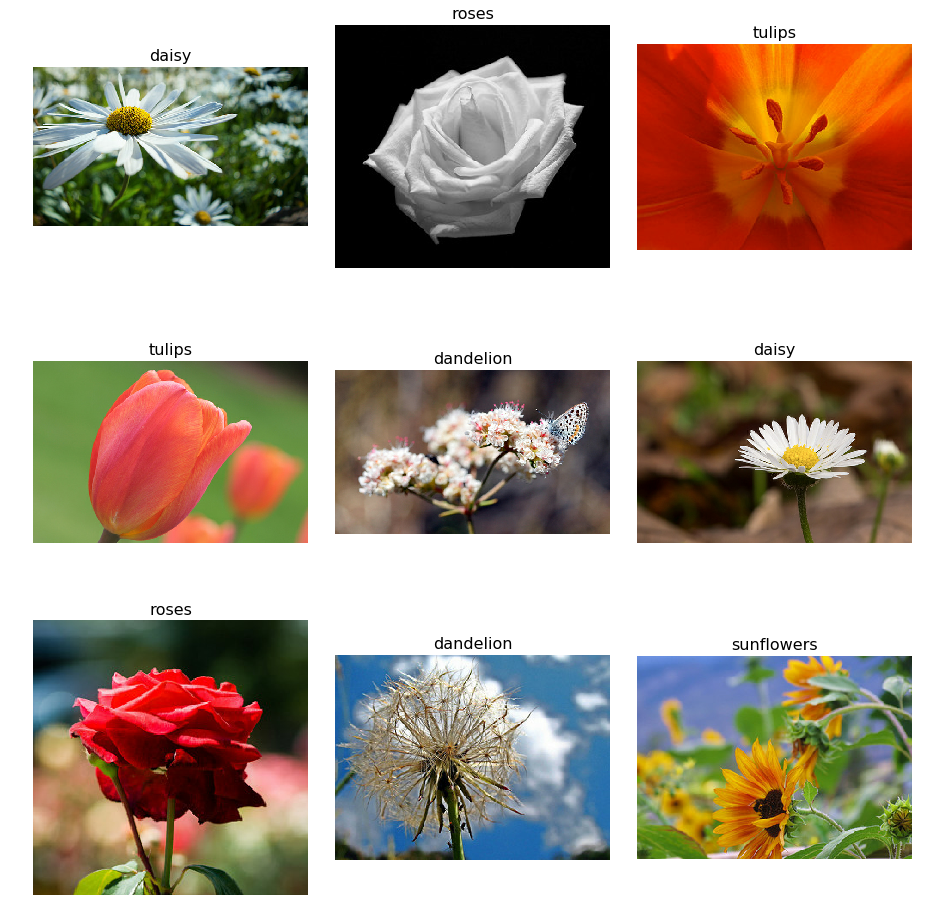

In [7]:
display_9_images_from_dataset(dataset1)

## Resize and crop images to common size
No need to study the code in this cell. It's only inage resizing.

In [0]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize_images(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize_images(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

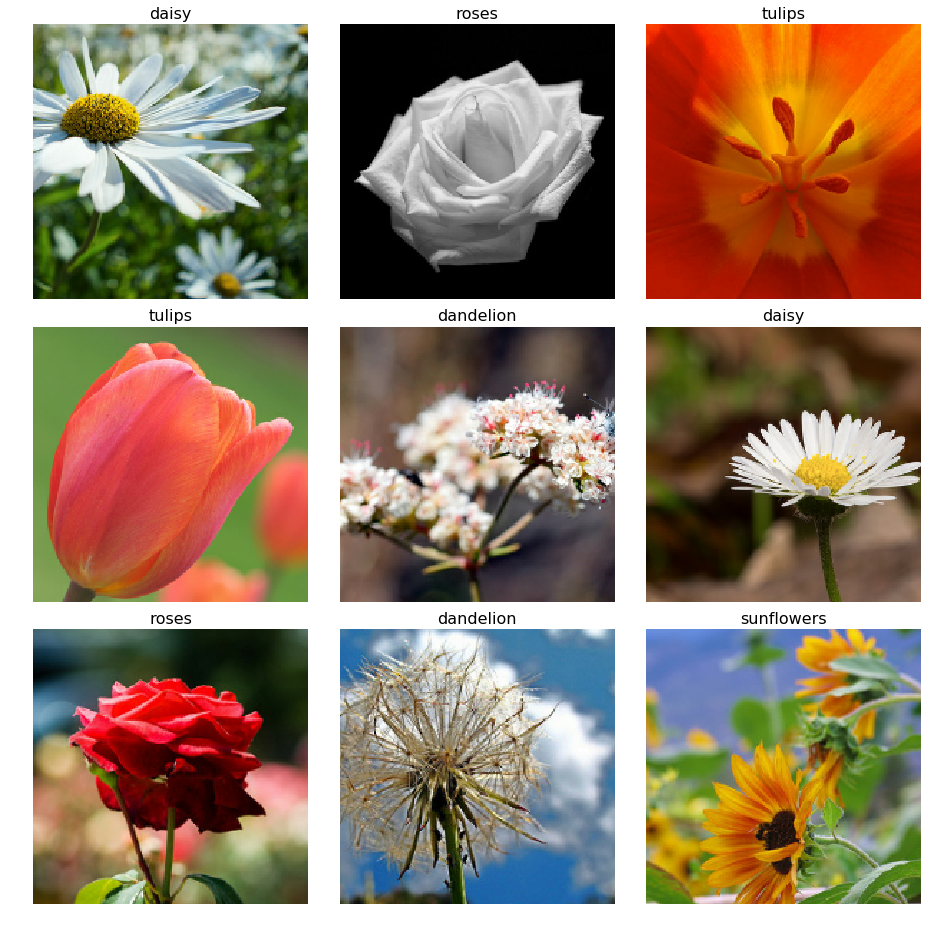

In [9]:
display_9_images_from_dataset(dataset2)

### Speed test: too slow
Google Cloud Storage is capable of great throughput but has a per-file access penalty. Run the cell below and see that throughput is around 8 images per second. That is too slow. Training on thousands of individual files will not work. We have to use the **TFRecord** format to group files together. 

In [10]:
display_dataset = dataset2.batch(8)
for image, label in display_dataset.take(30):
  print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['daisy', 'roses', 'tulips', 'tulips', 'dandelion', 'daisy', 'roses', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['sunflowers', 'daisy', 'tulips', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'tulips', 'roses', 'sunflowers', 'dandelion', 'sunflowers', 'daisy', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['sunflowers', 'sunflowers', 'daisy', 'tulips', 'tulips', 'dandelion', 'roses', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'sunflowers', 'tulips', 'daisy', 'daisy', 'dandelion', 'dandelion', 'tulips'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'roses', 'dandelion', 'daisy', 'roses', 'tulips', 'daisy', 'roses'])
Image batch shape (8, 192, 192, 3), ['tulips', 'daisy', 'daisy', 'roses', 'sunflowers', 'dandelion', 'tulips', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['roses', 'dandelion', 'roses', 'dandelion', 'dandelion', 'roses', 'sunfl

## Recompress the images
The bandwidth savings outweight the decoding CPU cost

In [0]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

## Write dataset to TFRecord files
**Students, do not run this cell, just read through.**

You do not have write access to the output bucket so you would get an error. Read through the code to amiliarize yourself with TFRecord encoding.

In [0]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()) # variable length  list of floats, n=len(CLASSES)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.python_io.TFRecordWriter(filename) as file:
    for i in range(shard_size):
      example = to_tfrecord(file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

## Read  from TFRecord Dataset
**Resume running the cells**

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
# to read from multiple TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

dataset4 = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec")
dataset4 = dataset4.with_options(option_no_order)
#dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
dataset4 = dataset4.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

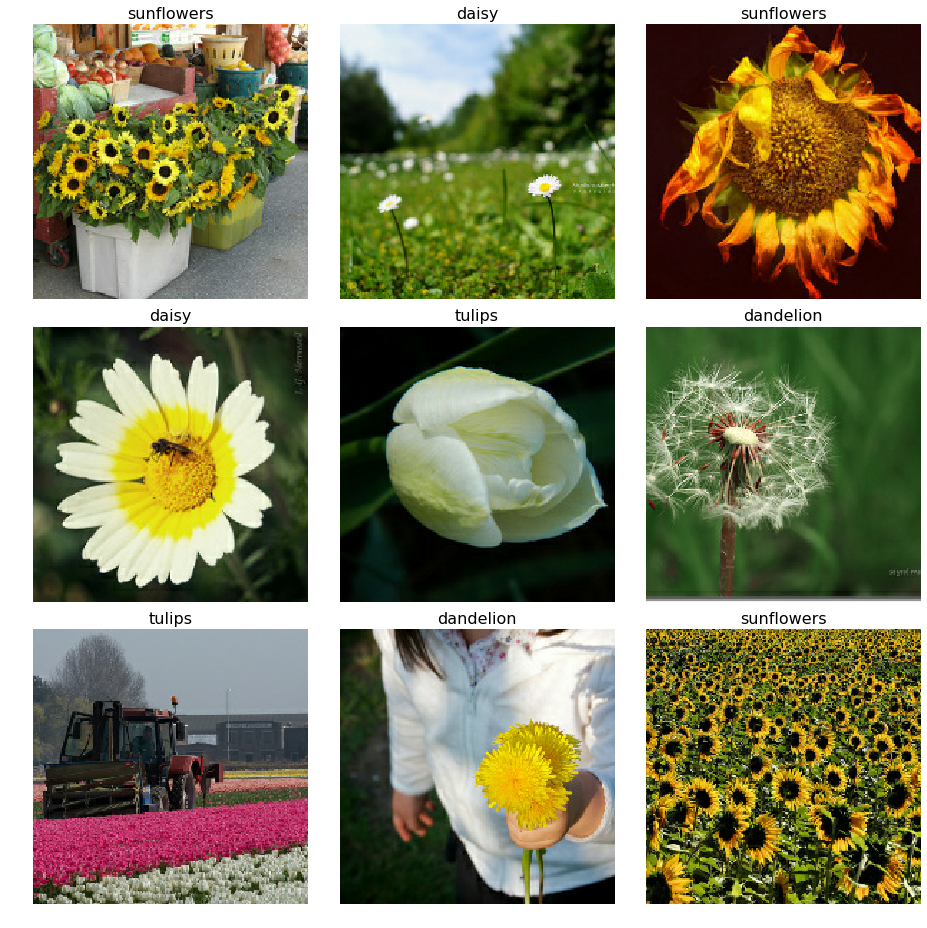

In [13]:
display_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))
display_9_images_from_dataset(display_dataset)

### Speed test: fast
Loading training data is not a bottleneck anymore

In [14]:
for image, class_num, label, height, width, one_hot_class in dataset4.take(300):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num, label.numpy().decode('utf8'), one_hot_class))

Image shape (192, 192, 3), 192x192 px, class=1 ( dandelion, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=4 (    tulips, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=1 ( dandelion, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=3 (sunflowers, [0. 0. 0. 1. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=2 (     roses, [0. 0. 1. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=1 ( dandelion, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=2 (     roses, [0. 

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
